In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from optuna.exceptions import ExperimentalWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ExperimentalWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np
import pandas as pd
import time

from pyspark.sql import SparkSession
from replay.utils.session_handler import get_spark_session, State

from replay.models import UCB, Wilson, RandomRec, LinUCB
from replay.experimental.scenarios.movielens_wrapper.replay_offline import OBPOfflinePolicyLearner
from replay.experimental.scenarios.movielens_wrapper.MIPS import MIPS
from replay.experimental.scenarios.movielens_wrapper.dataset import MovielensBanditDataset
from replay.experimental.scenarios.movielens_wrapper.utils import get_est_rewards_by_reg, bandit_subset

import obp
from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    DirectMethod,
    InverseProbabilityWeighting,
    DoublyRobust,
    SelfNormalizedInverseProbabilityWeighting,
    SelfNormalizedDoublyRobust,
    MarginalizedInverseProbabilityWeighting,
)

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


In [4]:
spark = State(get_spark_session()).session
spark.sparkContext.setLogLevel('ERROR')

24/09/07 23:06:53 WARN Utils: Your hostname, sudakovcom-MS-7D48 resolves to a loopback address: 127.0.1.1; using 10.255.173.26 instead (on interface enp3s0)
24/09/07 23:06:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/07 23:06:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/07 23:06:54 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


Lets define OpenBanditDataset class with random policy. For the purpose of demonstration we won't use the whole dataset but only subset of size 10000.

In [5]:
from rs_datasets import MovieLens

data = MovieLens("1m")
data.info()

ratings


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968



users


,user_id,gender,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117



items


,item_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [28]:
dataset = MovielensBanditDataset(data)

07-Sep-24 23:38:01, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
INFO:replay:Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.
07-Sep-24 23:38:02, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
07-Sep-24 23:38:03, replay, INFO: Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.
INFO:replay:Column with ids of users or items is absent in mapping. The dataframe will be treated as a users'/items' features dataframe.


fit started


INFO:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/py4j/clientserver.py", line 503, in send_command
    self.socket.sendall(command.encode("utf-8"))
ConnectionResetError: [Errno 104] Connection reset by peer

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/sudakovcom/Desktop/RePlayHDILab2024/.conda/lib/python3.9/site-packages/py4j/clientserver.py", line 506, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending
1880.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1880.28s - pydevd: Sending message related to process being replaced timed-out afte

predict started


100%|██████████| 5000/5000 [00:01<00:00, 4776.19it/s]


In [29]:
dataset.item_features.show(5)

+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|item_idx|Mystery|Action|Documentary|Children's|Drama|Adventure|Film-Noir|Crime|Animation|Fantasy|Comedy|Western|Romance|Thriller|War|Sci-Fi|Musical|Horror|
+--------+-------+------+-----------+----------+-----+---------+---------+-----+---------+-------+------+-------+-------+--------+---+------+-------+------+
|      32|      0|     0|          0|         1|    0|        0|        0|    0|        1|      0|     1|      0|      0|       0|  0|     0|      0|     0|
|     257|      0|     0|          0|         1|    0|        1|        0|    0|        0|      1|     0|      0|      0|       0|  0|     0|      0|     0|
|    1361|      0|     0|          0|         0|    0|        0|        0|    0|        0|      0|     1|      0|      1|       0|  0|     0|      0|     0|
|     953|      0|     0|          0|         0|    1|    

In [30]:
dataset.user_features.show(5)

+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+
|user_idx|agegroup_20-29|agegroup_30-39|agegroup_40-49|agegroup_51-60|agegroup_<20|gender_F|gender_M|occupation_0|occupation_1|occupation_2|occupation_3|occupation_4|occupation_5|occupation_6|occupation_7|occupation_8|occupation_9|occupation_10|occupation_11|occupation_12|occupation_13|occupation_14|occupation_15|occupation_16|occupation_17|occupation_18|occupation_19|occupation_20|
+--------+--------------+--------------+--------------+--------------+------------+--------+--------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [31]:
dataset.log.show(5)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|      24|      50|        1|2001-01-01 01:12:40|
|      24|     980|        1|2001-01-01 01:35:09|
|      24|     328|        1|2001-01-01 01:32:48|
|      24|      85|        1|2001-01-01 01:04:35|
|      24|      16|        1|2001-01-07 02:38:11|
+--------+--------+---------+-------------------+
only showing top 5 rows



In [32]:
dataset.context

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [33]:
dataset.action_context

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [76]:
bandit_feedback_train, bandit_feedback_test = dataset.obtain_batch_bandit_feedback(test_size=0.3, is_timeseries_split=True)

print(bandit_feedback_train["n_rounds"])
print(bandit_feedback_test["n_rounds"])

100%|██████████| 14/14 [00:00<00:00, 2798.47it/s]

3498
14


In [77]:
bandit_feedback_train.keys()

dict_keys(['log', 'item_features', 'user_features', 'n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context'])

The keys of the dictionary are as follows.
- n_rounds: number of rounds, data size of the logged bandit data;
- n_actions: number of actions $|\mathcal{A}|$;
- action: action variables sampled by the behavior policy;
- position: positions where actions are recommended, there are three positions in the ZOZOTOWN rec interface;
- reward: binary reward variables, click indicators;
- pscore: action choice probabilities by the behavior policy, propensity scores;
- context: context vectors such as user-related features and user-item affinity scores;
- action_context: item-related context vectors

In [78]:
#Define replay model
model_1 = UCB(exploration_coef =2.0, sample= False, seed= 123)
model_2 = LinUCB(eps = 10.0, alpha = 1.0, regr_type = 'disjoint')
model_3 = RandomRec(seed=42)

#Define learner which connects OBP data format with replay
learner_1 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_1,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user
learner_2 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_2,
                                    len_list=dataset.len_list,) #len_list is the number of predicted items per user

learner_3 = OBPOfflinePolicyLearner(n_actions=dataset.n_actions,
                                    replay_model=model_3,
                                    len_list=dataset.len_list,)

**RePlayOfflinePolicyLearner** has the following methods
- *fit(action, reward, timestamp, context, action_context)*;
- *predict(n_rounds, context)* (context can be None thus n_rounds is **required**);
- *optimize(bandit_feedback, val_size, param_borders, criterion, budget, new_study)*

In [79]:
bandit_feedback_train['log'].show(3)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|       9|     229|        1|2000-12-31 08:38:32|
|       9|     281|        0|2000-12-31 08:37:52|
|       9|     166|        1|2000-12-31 08:37:52|
+--------+--------+---------+-------------------+
only showing top 3 rows



In [80]:
#Fit replay model inside our learner
learner_1.fit(bandit_feedback_train)
# learner_2.fit(bandit_feedback_train)
learner_3.fit(bandit_feedback_train)

In [81]:
estimated_rewards_by_reg_model = get_est_rewards_by_reg(dataset.n_actions,
                                                        dataset.len_list,
                                                        bandit_feedback_train,
                                                        bandit_feedback_test)

When we get distribution over actions - we can run any evaluation procedure from the OBP. Here we use three estimators
- *IPW*: Average rewards with importance weights
- *DM*: Average predicted rewards using the classifier
- *DR*: Combination of the above methods with zero bias and lower variance

Also, we can construct confidence intervals for each of these methods.

In [82]:
def get_dist(learner):
    all_action_dist = np.zeros((bandit_feedback_test["n_rounds"], dataset.n_actions, dataset.len_list))
    batch_size = 300
    num_batchs = bandit_feedback_test["n_rounds"] // batch_size
    for i in range(num_batchs+1):
        j = min((i+1)*batch_size, bandit_feedback_test["n_rounds"])
        bandit_feedback_subset = bandit_subset([i*batch_size, j], bandit_feedback_test) #The first parameter is a slice of subset [a, b]
        print(type(bandit_feedback_subset["log"].select('user_idx')))
        print(bandit_feedback_subset["log"].select('user_idx').count())
        action_dist = learner.predict(bandit_feedback_subset["n_rounds"], bandit_feedback_subset["log"].select('user_idx'))
        all_action_dist[i*batch_size:j, :, :] = action_dist
    return all_action_dist

In [83]:
#Predict distribution over actions: shape (n_rounds, n_actions, len_list)
import time
start = time.time()
learner_action_dist_1 = get_dist(learner_1)
print(time.time() - start)

# start = time.time()
# learner_action_dist_2 = get_dist(learner_2)
# print(time.time() - start)

start = time.time()
learner_action_dist_3 = get_dist(learner_3)
print(time.time() - start)

<class 'pyspark.sql.dataframe.DataFrame'>
14
0.2971057891845703
<class 'pyspark.sql.dataframe.DataFrame'>
14
0.24689841270446777


/home/sudakovcom/Desktop/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


In [84]:
def run_exp(learner_action_dist):
    Vs = []
    CIs = []

    # for n_size in [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]:
    for n_size in [1, 2, 3, 5, bandit_feedback_test["n_rounds"]]:
        start = time.time()
        bandit_feedback_subset = bandit_subset([0, n_size], bandit_feedback_test) #The first parameter is a slice of subset [a, b]

        ope = OffPolicyEvaluation(
            bandit_feedback=bandit_feedback_subset,
            ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), SelfNormalizedDoublyRobust(),
                            SelfNormalizedInverseProbabilityWeighting(),]
        )

        estimated_rewards_by_reg_model_subset = estimated_rewards_by_reg_model[0: n_size, :, :]
        
        action_dist = learner_action_dist[:n_size, :, :]
        estimated_policy_value = ope.estimate_policy_values(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
        )

        estimated_ci = ope.estimate_intervals(
            action_dist=action_dist,
            estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_subset,
            n_bootstrap_samples=10000,
            random_state=12345,)
        end = time.time()
        print("n_size =", n_size, "time: ", end-start)
        Vs.append(estimated_policy_value)
        CIs.append(estimated_ci)
    return(Vs, CIs)

In [85]:
learner_action_dist_1.shape

(14, 1647, 1)

In [86]:
dataset.position

array([0, 0, 0, ..., 0, 0, 0])

In [87]:
bandit_feedback_test['position']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [88]:
Vs_1, CIs_1 = run_exp(learner_action_dist_1)

n_size = 1 time:  0.6615219116210938
n_size = 2 time:  0.6793968677520752
n_size = 3 time:  0.6738417148590088
n_size = 5 time:  0.6665143966674805
n_size = 14 time:  0.6901514530181885


In [26]:
Vs_2, CIs_2 = run_exp(learner_action_dist_2)

n_size = 300 time:  0.5477616786956787
n_size = 600 time:  0.7000432014465332
n_size = 900 time:  0.5940260887145996
n_size = 1200 time:  1.0209970474243164
n_size = 1500 time:  0.9127945899963379


In [89]:
Vs_3, CIs_3 = run_exp(learner_action_dist_3)

n_size = 1 time:  0.6624670028686523
n_size = 2 time:  0.6812162399291992
n_size = 3 time:  0.6637387275695801
n_size = 5 time:  0.6688389778137207
n_size = 14 time:  0.6815807819366455


In [90]:
import matplotlib.pyplot as plt
def plot_disjoint_res(Vs, CIs, model): 
    fig, ax = plt.subplots(4, figsize=(10, 10))

    # x = [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]
    x = [1, 2, 3, 5, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax[i].plot(x, y_est, '-', label=name, color = colors[i])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

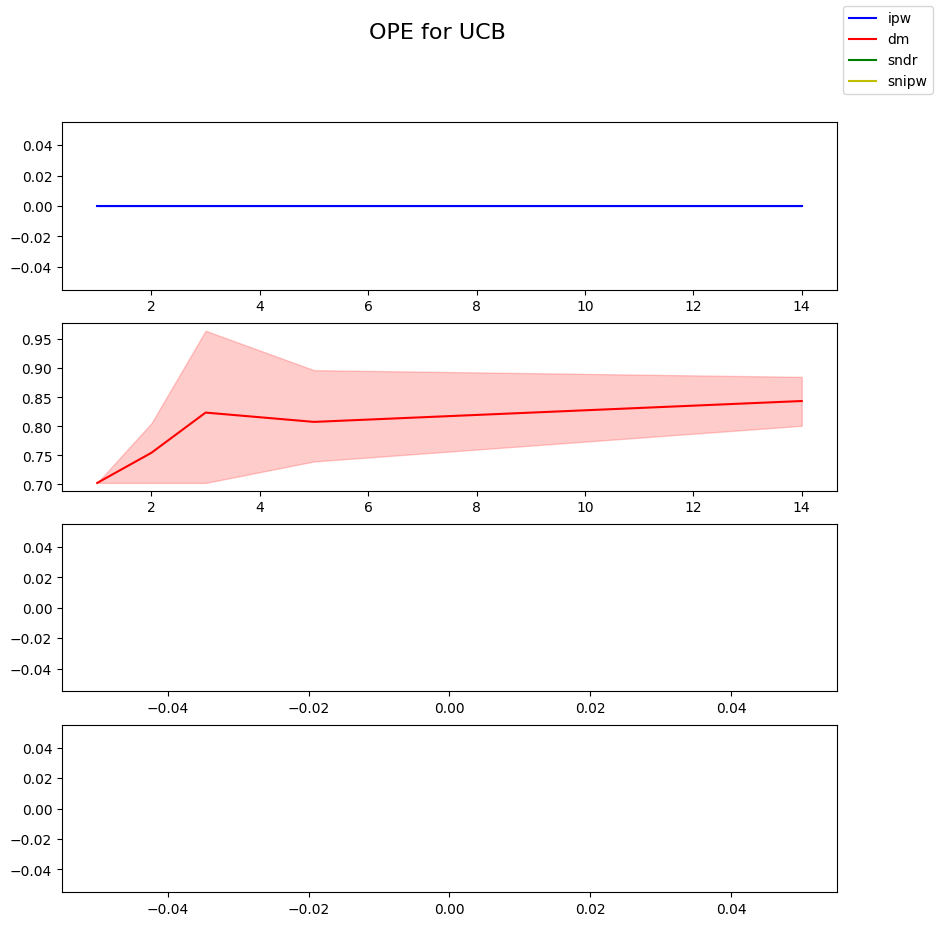

In [91]:
plot_disjoint_res(Vs_1, CIs_1, 'UCB')

In [92]:
plot_disjoint_res(Vs_2, CIs_2, 'Lin_UCB')

NameError: name 'Vs_2' is not defined

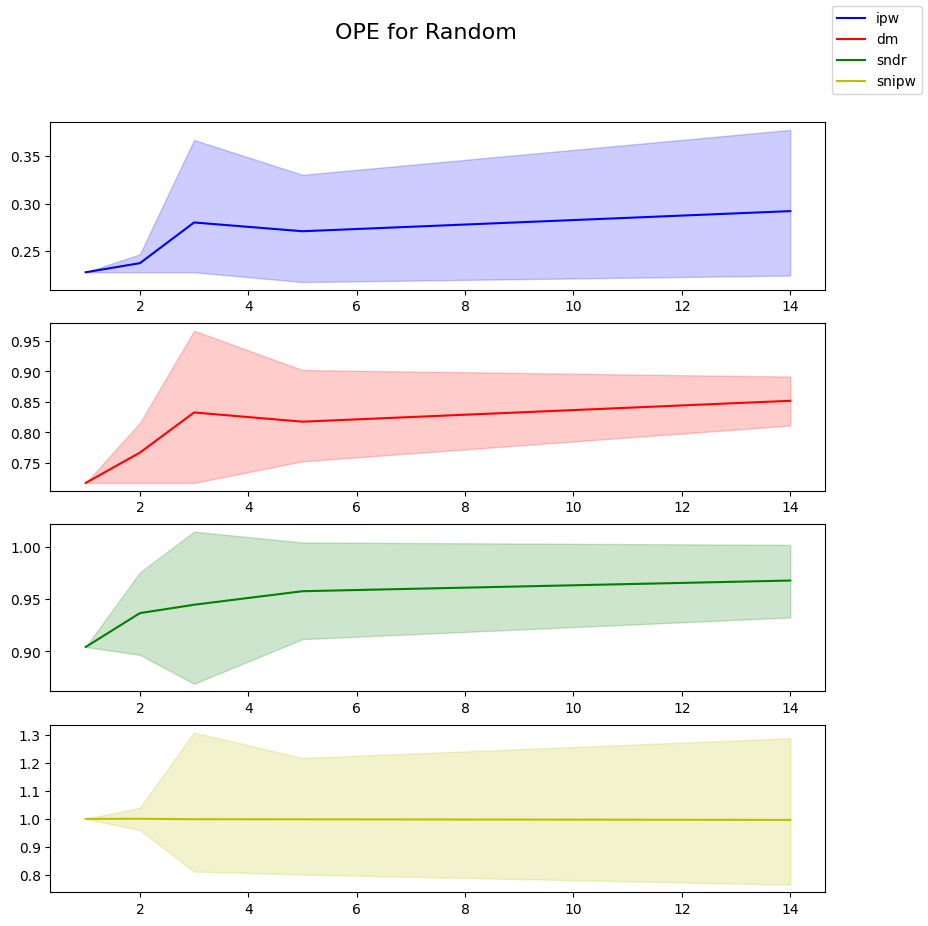

In [93]:
plot_disjoint_res(Vs_3, CIs_3, 'Random')

In [32]:
out_str = f"Scores for UCB true"
for key, val in Vs_1[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for UCB true ipw : 0.000, dm : 885.237, sndr : nan, snipw : nan


In [33]:
out_str = f"Scores for Lin_UCB true"
for key, val in Vs_2[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for Lin_UCB true ipw : 374.487, dm : 883.531, sndr : 851.949, snipw : 820.267


In [34]:
out_str = f"Scores for random true"
for key, val in Vs_3[-1].items():
    out_str += f" {key} : {(1e3 * val):.3f},"
out_str = out_str[:-1]
print(out_str)

Scores for random true ipw : 338.878, dm : 883.919, sndr : 809.635, snipw : 809.499


In [35]:
print("USB all")
print(Vs_1)

USB all
[{'ipw': 0.0, 'dm': 0.9420824656177554, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.889479802918651, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.888508810004672, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8757488325488236, 'sndr': nan, 'snipw': nan}, {'ipw': 0.0, 'dm': 0.8852370925672933, 'sndr': nan, 'snipw': nan}]


In [36]:
print("Lin USB all")
print(Vs_2)

Lin USB all
[{'ipw': 0.47828259872295786, 'dm': 0.9397628443594855, 'sndr': 1.0007903522606114, 'snipw': 1.0}, {'ipw': 0.5641045049233597, 'dm': 0.886916811747552, 'sndr': 1.094215112194451, 'snipw': 1.0}, {'ipw': 0.3760696699489065, 'dm': 0.8872290843126451, 'sndr': 0.9187454982830104, 'snipw': 0.8452982431176718}, {'ipw': 0.38415555580384003, 'dm': 0.8738856848217768, 'sndr': 0.8269972647126279, 'snipw': 0.7892659288133212}, {'ipw': 0.3744873098047868, 'dm': 0.8835311142302265, 'sndr': 0.8519491897158777, 'snipw': 0.8202674010793207}]


In [37]:
print("Random all")
print(Vs_3)

Random all
[{'ipw': 0.3327567609391204, 'dm': 0.9410966127201909, 'sndr': 0.7587695499987541, 'snipw': 0.7629587796924234}, {'ipw': 0.36777738117348785, 'dm': 0.8883471979137172, 'sndr': 0.8302114981079703, 'snipw': 0.8313495956950725}, {'ipw': 0.34234056068222307, 'dm': 0.8872856243132855, 'sndr': 0.8186546290422994, 'snipw': 0.8198339424200453}, {'ipw': 0.33612225449170524, 'dm': 0.8743907134183376, 'sndr': 0.8075495578845954, 'snipw': 0.8076207427705235}, {'ipw': 0.338877904474602, 'dm': 0.8839189576114012, 'sndr': 0.809635174546697, 'snipw': 0.8094993331860039}]


In [38]:
print("Estimated confidence intervals UCB:")
print(pd.DataFrame(CIs_1[-1]).to_string())
print("Estimated confidence intervals Lin UCB:")
print(pd.DataFrame(CIs_2[-1]).to_string())
print("Estimated confidence intervals Random:")
print(pd.DataFrame(CIs_3[-1]).to_string())

Estimated confidence intervals UCB:
                  ipw        dm  sndr  snipw
mean              0.0  0.885241   NaN    NaN
95.0% CI (lower)  0.0  0.880484   NaN    NaN
95.0% CI (upper)  0.0  0.889884   NaN    NaN
Estimated confidence intervals Lin UCB:
                       ipw        dm      sndr     snipw
mean              0.375072  0.883535  0.852060  0.821549
95.0% CI (lower)  0.149587  0.878710  0.570164  0.327653
95.0% CI (upper)  0.644020  0.888260  1.070557  1.410645
Estimated confidence intervals Random:
                       ipw        dm      sndr     snipw
mean              0.338917  0.883923  0.809710  0.809593
95.0% CI (lower)  0.327786  0.879143  0.787210  0.783004
95.0% CI (upper)  0.350174  0.888586  0.831354  0.836484


In [93]:
def plot_res_two_politics(CIs_p1, CIs_p2, model_p1, model_p2):
    fig, ax = plt.subplots(4, figsize=(15, 10))
    x = [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i=0
    for name in ['ipw', 'dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p1]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p1]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p1]

        ax[i].plot(x, y_est, '-', label=model_p1+"_"+name, color = colors[0])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[0])
        
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs_p2]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs_p2]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs_p2]

        ax[i].plot(x, y_est, '-', label=model_p2+"_"+name, color = colors[1])
        ax[i].fill_between(x, y_low, y_up, alpha=0.2, color = colors[1])
        ax[i].set_title(name)
        
        i = i+1
    fig.suptitle("OPE for " + model_p1 + " and " + model_p2, fontsize=16)
    fig.legend()

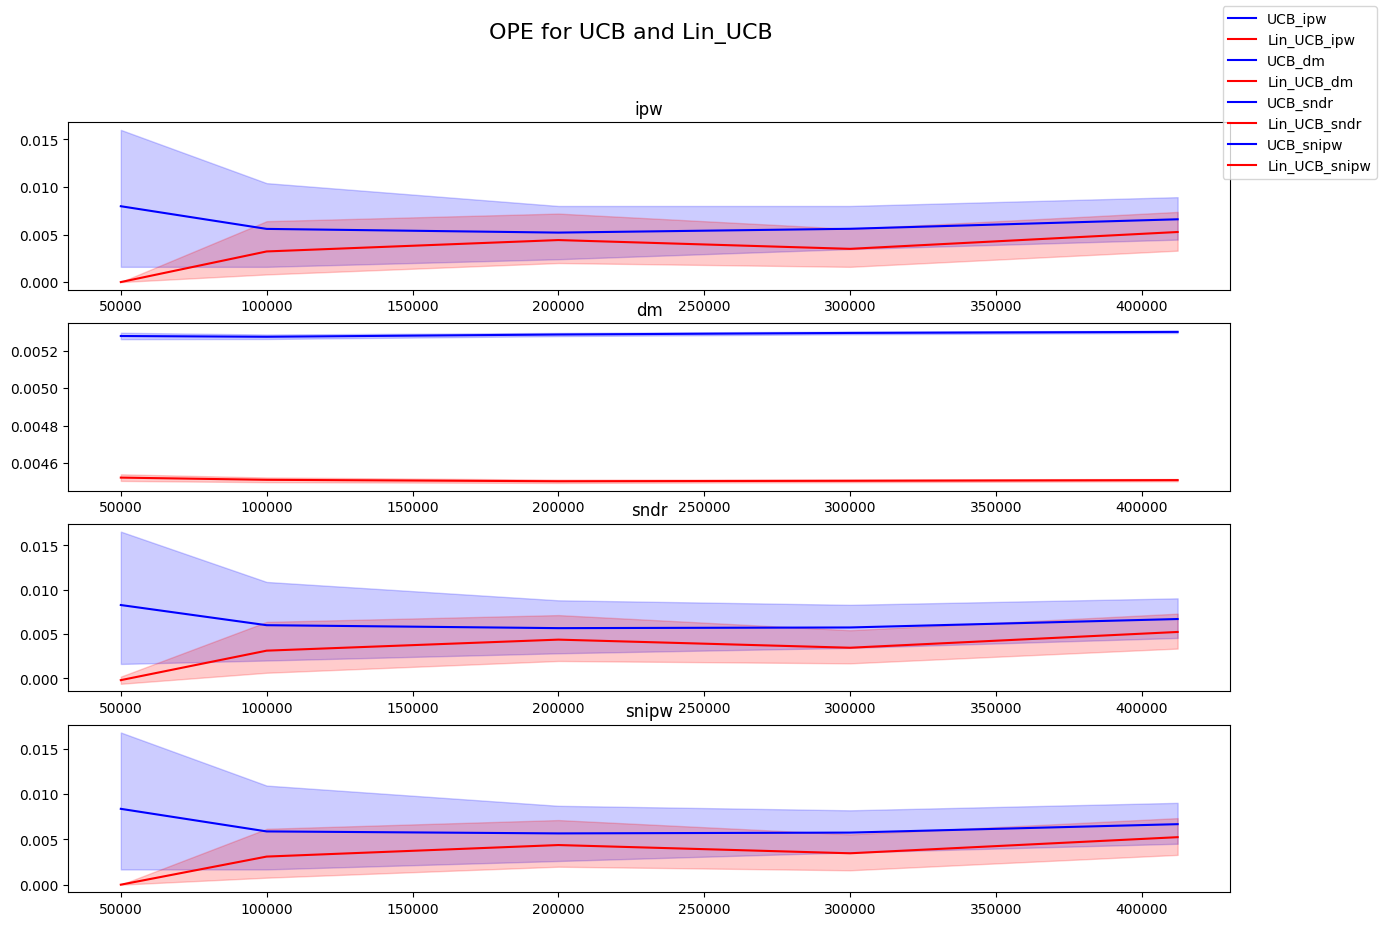

In [94]:
plot_res_two_politics(CIs_1, CIs_2, "UCB", "Lin_UCB")

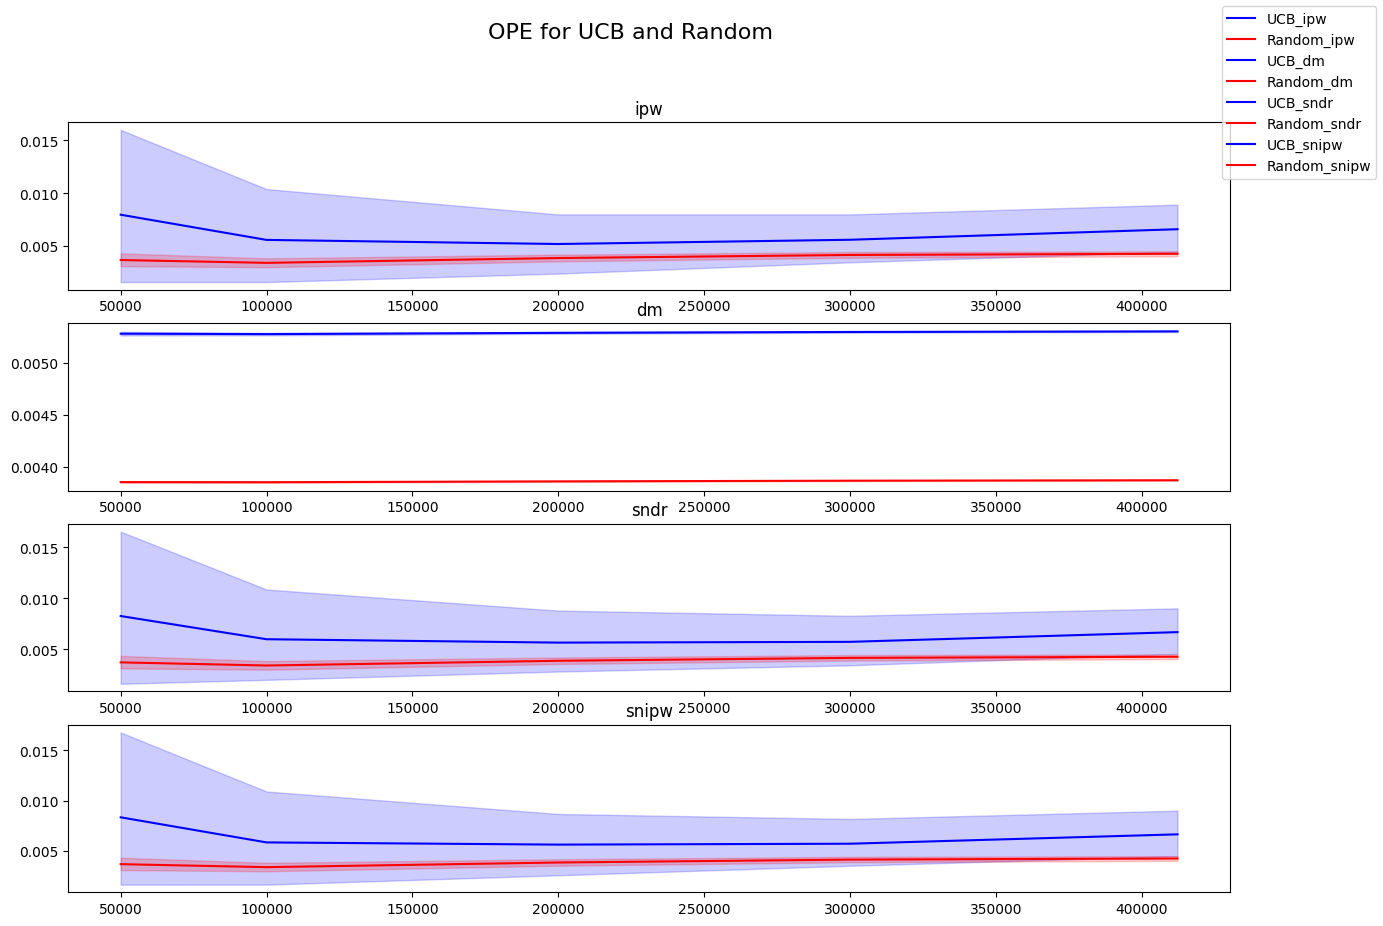

In [95]:
plot_res_two_politics(CIs_1, CIs_3, "UCB", "Random")

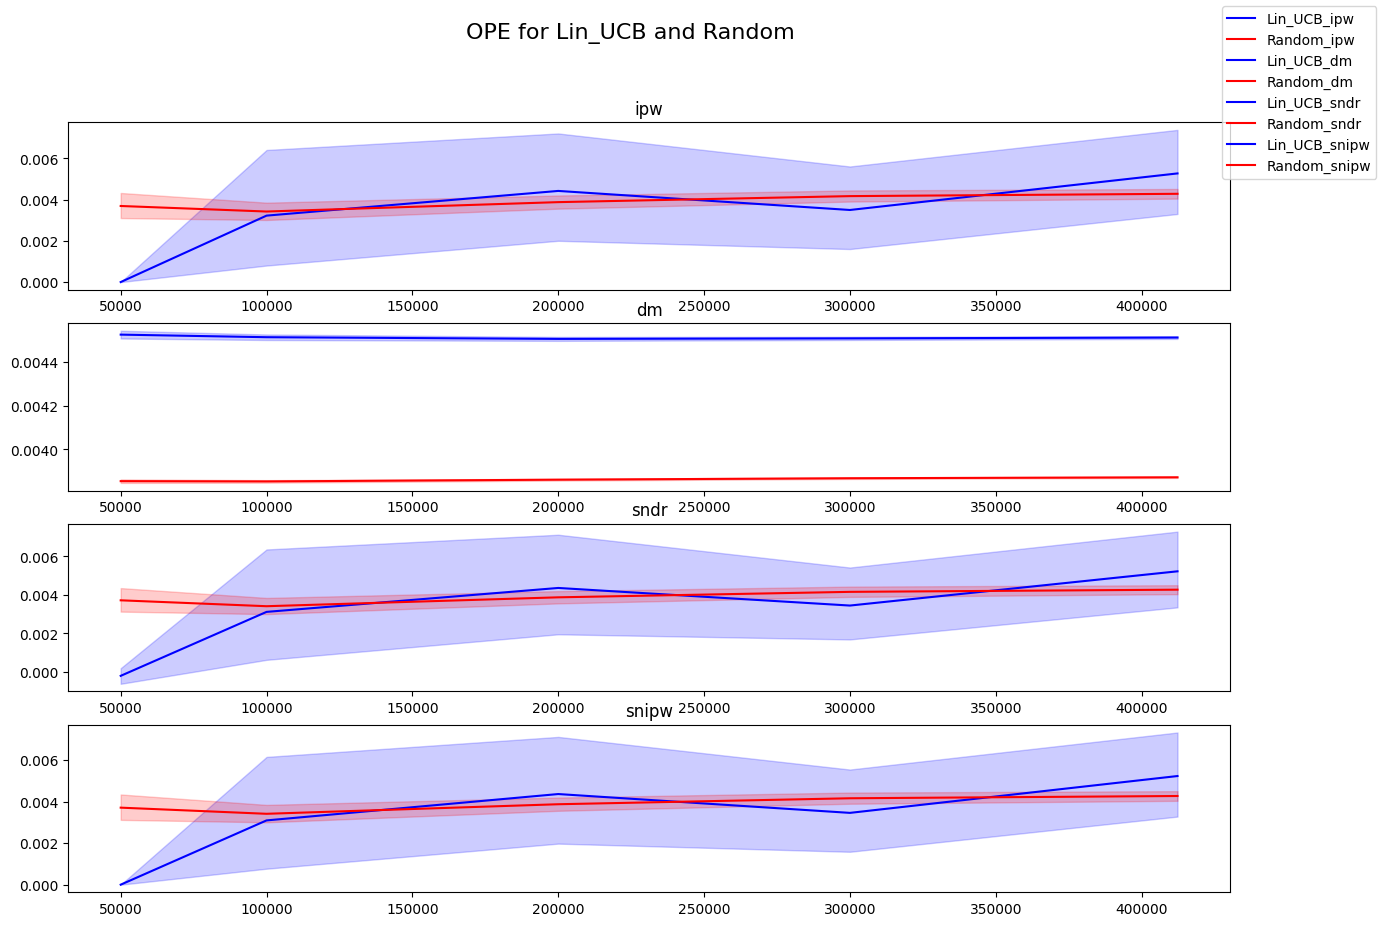

In [96]:
plot_res_two_politics(CIs_2, CIs_3, "Lin_UCB", "Random")

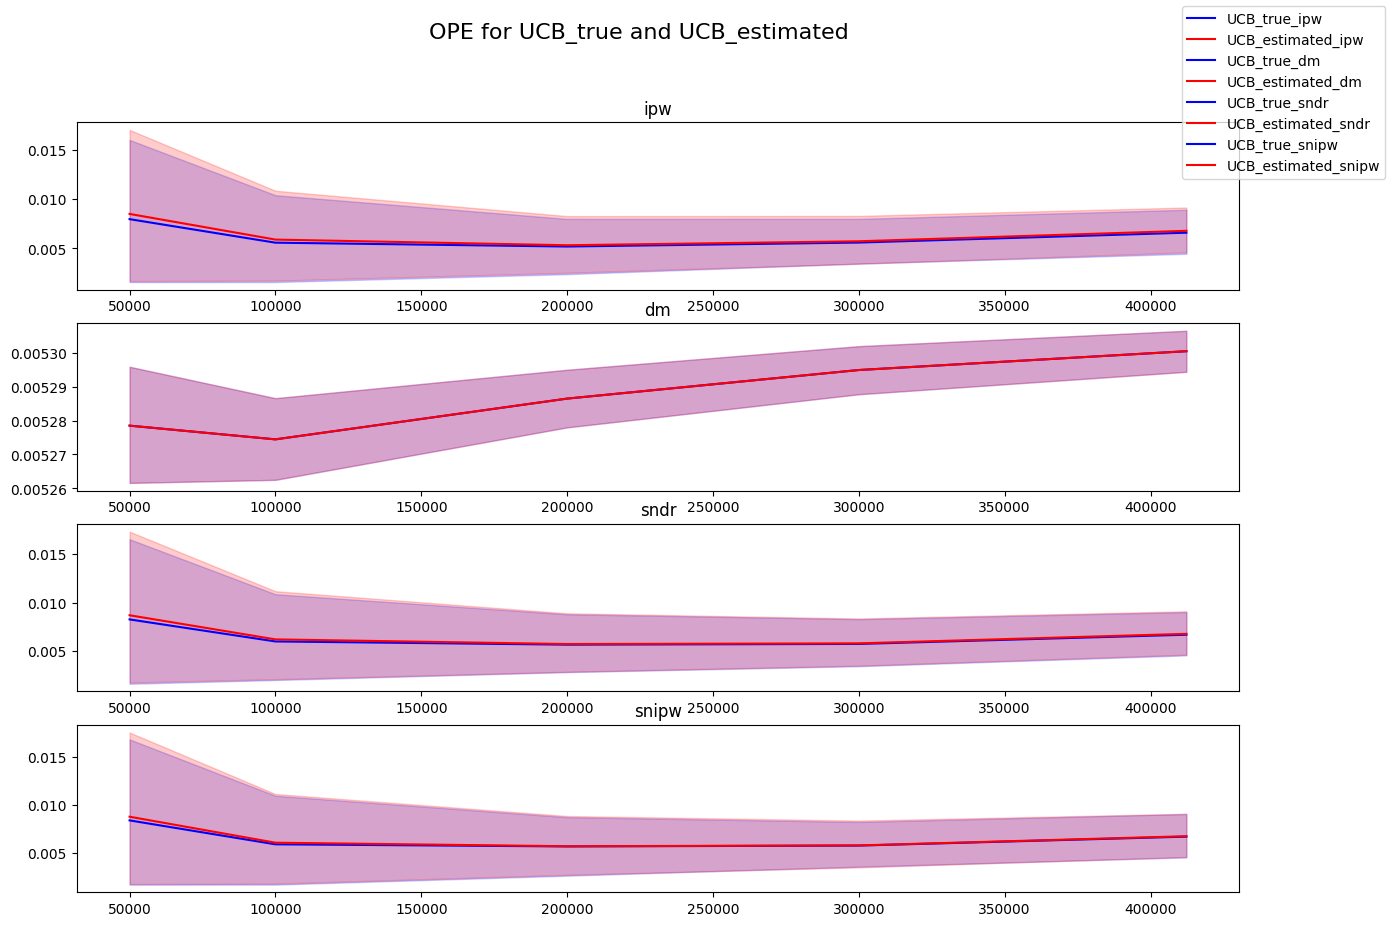

In [97]:
plot_res_two_politics(CIs_1, CIs_1_e, "UCB_true", "UCB_estimated")

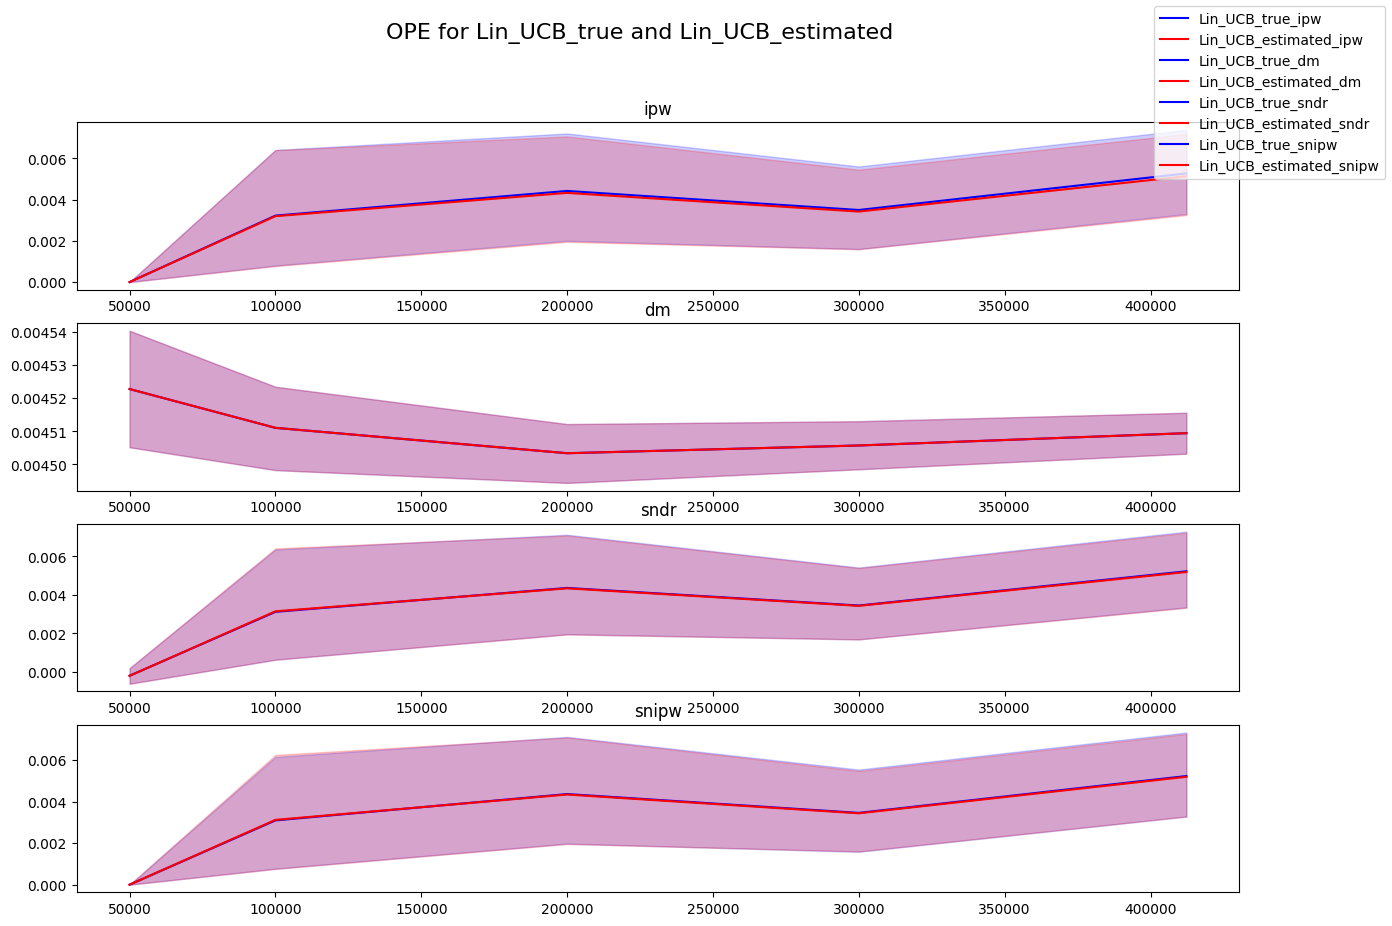

In [98]:
plot_res_two_politics(CIs_2, CIs_2_e, "Lin_UCB_true", "Lin_UCB_estimated")

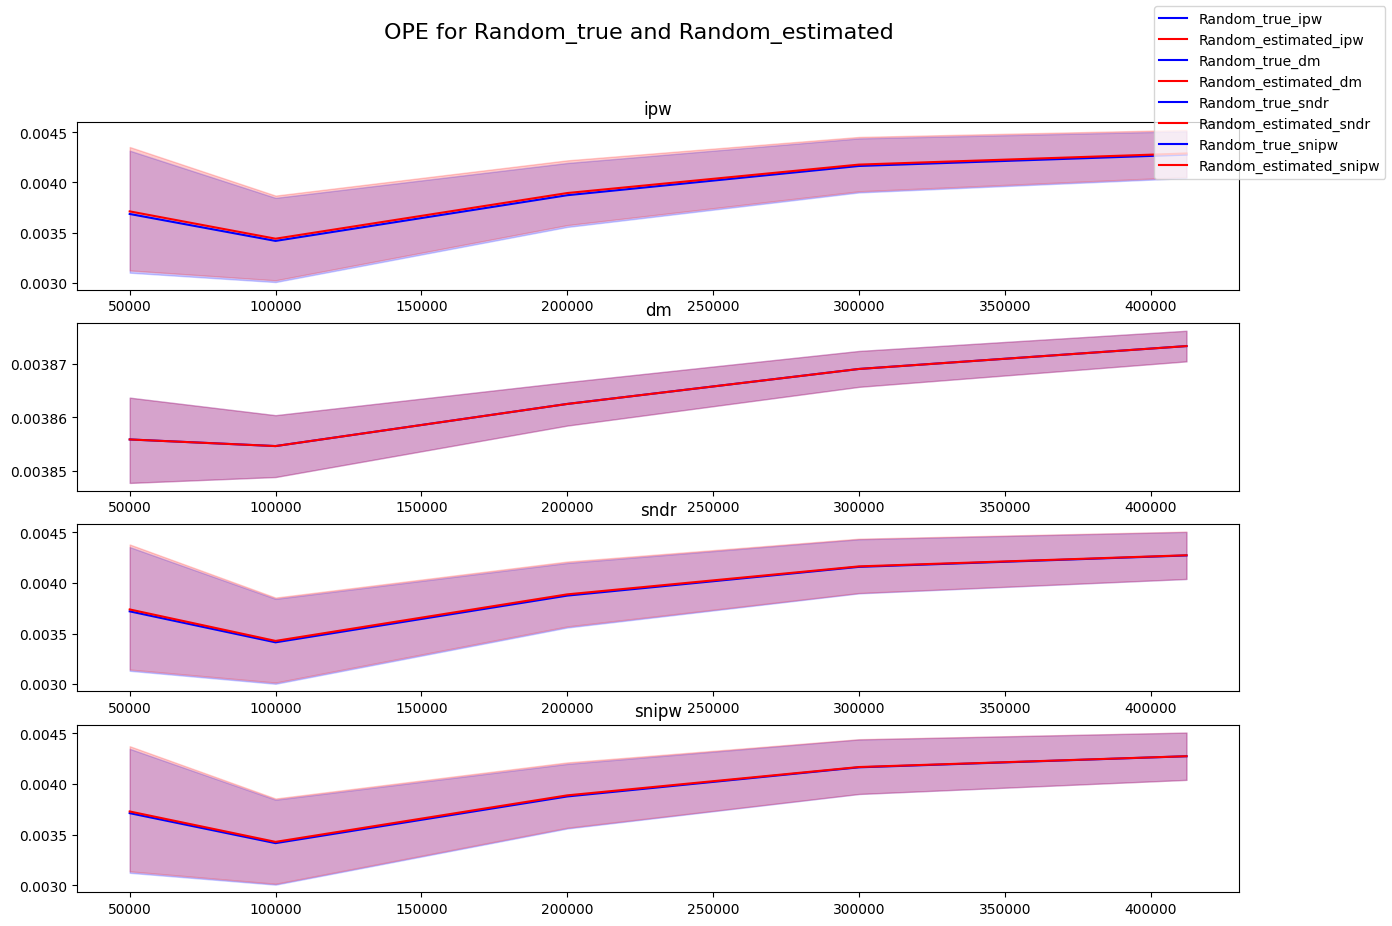

In [99]:
plot_res_two_politics(CIs_3, CIs_3_e, "Random_true", "Random_estimated")

In [36]:
def plot_join_res(Vs, CIs, model):
    fig, ax = plt.subplots(figsize=(10, 10))
    x = [50000, 100000, 200000, 300000, bandit_feedback_test["n_rounds"]]
    colors = ['b', 'r', 'g', 'y', 'k']
    i = 0
    for name in ['ipw','dm', 'sndr', 'snipw']:
        y_est = [estimated_ci[name]["mean"] for estimated_ci in CIs]
        y_up = [estimated_ci[name]["95.0% CI (upper)"] for estimated_ci in CIs]
        y_low = [estimated_ci[name]["95.0% CI (lower)"] for estimated_ci in CIs]

        ax.plot(x, y_est, '-', label=name, color = colors[i])
        ax.fill_between(x, y_low, y_up, alpha=0.2, color = colors[i])
        #ax.plot(x, y, 'o', color='tab:brown')
        i=i+1
    fig.suptitle("OPE for " + model, fontsize=16)
    fig.legend()

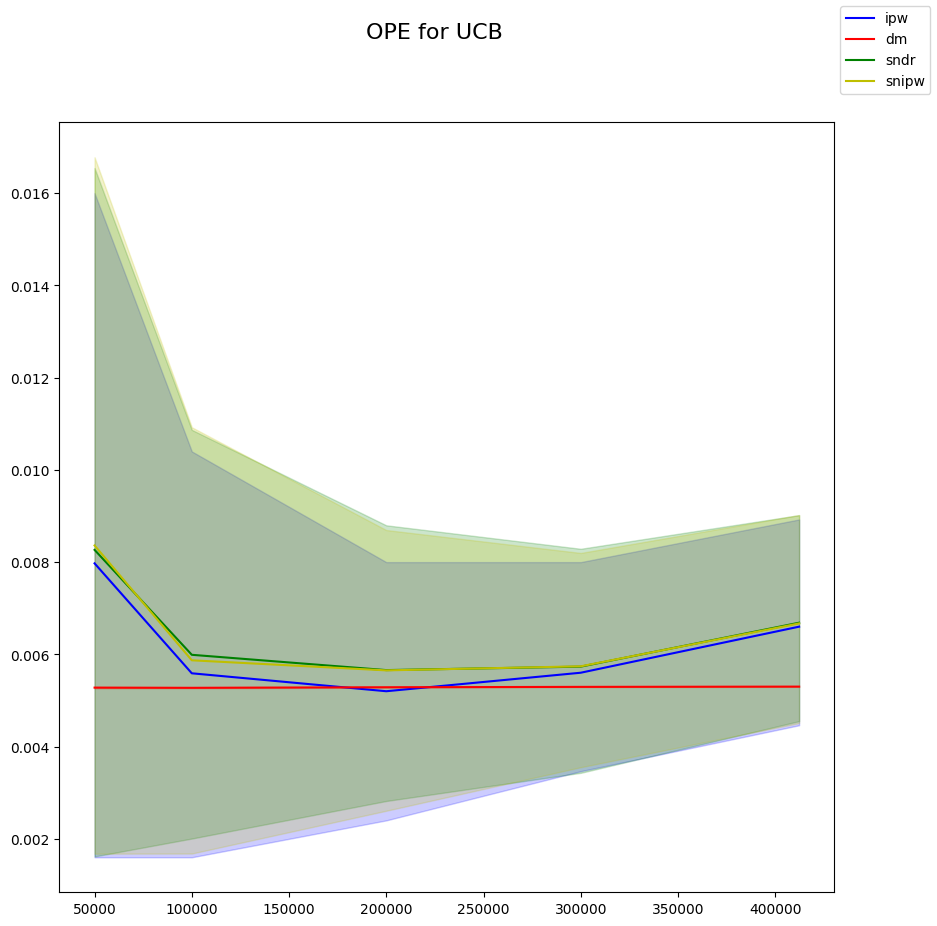

In [37]:
plot_join_res(Vs_1, CIs_1, 'UCB')

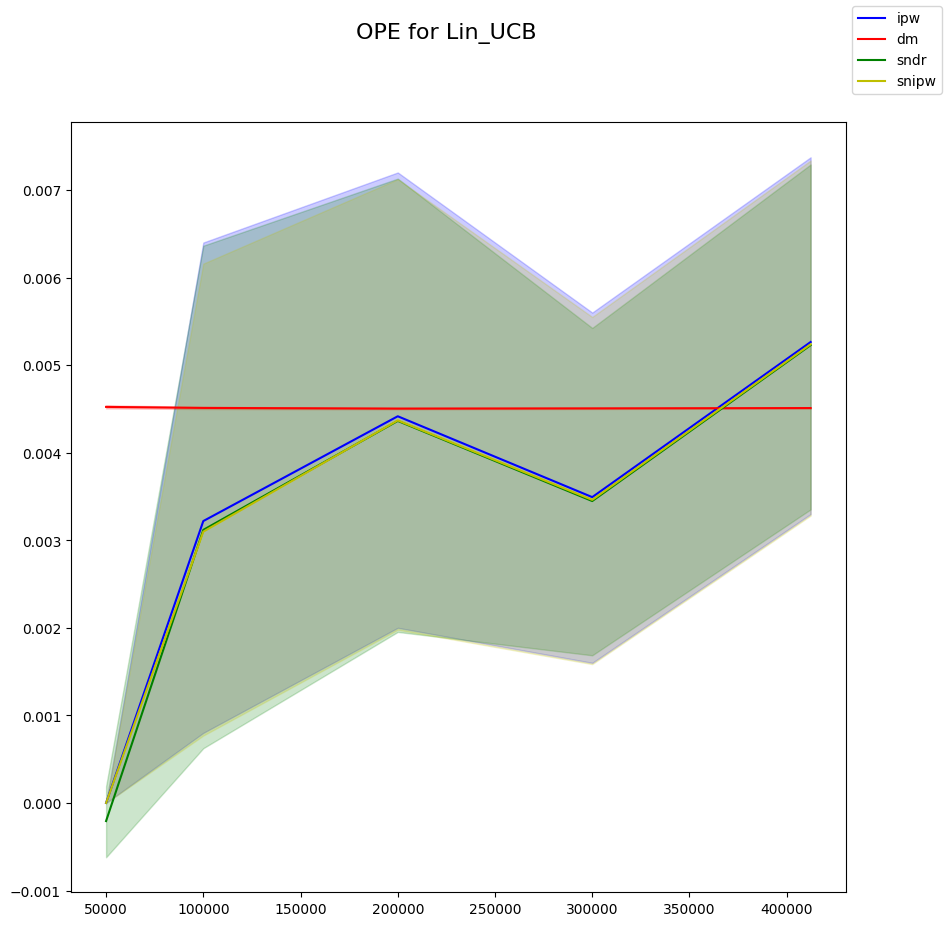

In [38]:
plot_join_res(Vs_2, CIs_2, 'Lin_UCB')

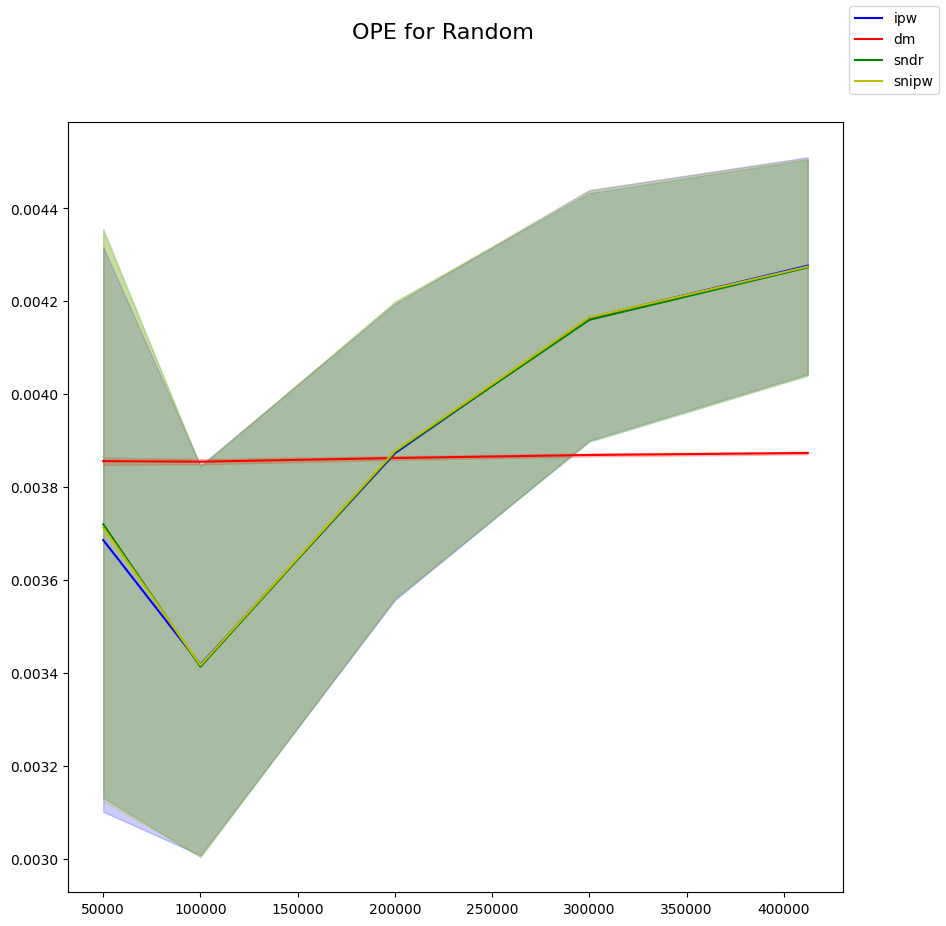

In [39]:
plot_join_res(Vs_3, CIs_3, 'Random')

In [40]:
print("ucb")
learner_1.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 1)

ucb


{'hr@1': 0.02837837837837838,
 'mrr@1': 0.02837837837837838,
 'ndcg@1': 0.02837837837837838,
 'cov@1': 0.0125}

In [41]:
print("Lin_ucb")
learner_2.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 1)

Lin_ucb


{'hr@1': 0.0222972972972973,
 'mrr@1': 0.0222972972972973,
 'ndcg@1': 0.0222972972972973,
 'cov@1': 0.3125}

In [42]:
print("Random")
learner_3.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 1)

Random


/home/hdilab04/marina/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


{'hr@1': 0.020945945945945947,
 'mrr@1': 0.020945945945945947,
 'ndcg@1': 0.020945945945945947,
 'cov@1': 1.0}

In [43]:
print("ucb")
learner_1.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 3)

ucb


{'hr@3': 0.075,
 'mrr@3': 0.04819819819819819,
 'ndcg@3': 0.055050899078186076,
 'cov@3': 0.0375}

In [44]:
print("Lin_ucb")
learner_2.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 3)

Lin_ucb


{'hr@3': 0.05878378378378379,
 'mrr@3': 0.03704954954954955,
 'ndcg@3': 0.04257525968388076,
 'cov@3': 0.6}

In [45]:
print("Random")
learner_3.predict_and_hit_rate(test_context_pos.shape[0], bandit_feedback_train['n_actions'], test_context_pos, test_actions_pos, 3)

Random


/home/hdilab04/marina/RePlayHDILab2024/replay/models/base_rec.py:1515: SparkCollectToMasterWarning: Prediction with sampling performs spark to pandas convertion to master node, this may lead to OOM exception for large item catalogue.
  warnings.warn(


{'hr@3': 0.041891891891891894,
 'mrr@3': 0.02477477477477478,
 'ndcg@3': 0.029150212220077694,
 'cov@3': 1.0}